# data612 - Group Project 3 : Recommender System (Matrix Factorization)
# date: 2019-06-25
# by: Sang Yoon (Andy) Hwang, Santosh Cheruku, Anthony Munoz

The purpose of this project is to show which algorithm works the best for prediction - SVD, NMF and ALS/SGD (the lowest RMSE).
We will use the algorithm that works the best to predict user ratings and recommend items.

# Data Preparation

We are going to use 100k ratings dataset from movielens.

In [140]:
import pandas as pd
import numpy as np
import surprise
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
from surprise import Dataset
from surprise import KNNBasic
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split

From https://grouplens.org/datasets/movielens/, ml-latest-small will be used.

In [141]:
df = pd.read_csv('https://raw.githubusercontent.com/san123i/CUNY/master/Semester2/612-RecommenderSystem/data/ml-100k/ratings.csv')

In [142]:
df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


Just to make our life a little bit easier, we will change the names of the columns.

In [143]:
df.columns = ['user','item','rating','timestamp']

In [144]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
user         100836 non-null int64
item         100836 non-null int64
rating       100836 non-null float64
timestamp    100836 non-null int64
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


# Modelling

We will find the best algorithm based on RMSE. 

In [145]:
reader = Reader(rating_scale=(df.rating.min(), df.rating.max()))
data = Dataset.load_from_df(df[['user', 'item', 'rating']], reader)

Let's split data into 5 folds

In [146]:
data.split(n_folds=5)

# SVD

In [147]:
algo = surprise.SVD()
rmse_svd = surprise.evaluate(algo, data, measures=['RMSE'])

Evaluating RMSE of algorithm SVD.

------------
Fold 1
RMSE: 0.8739
------------
Fold 2
RMSE: 0.8759
------------
Fold 3
RMSE: 0.8662
------------
Fold 4
RMSE: 0.8859
------------
Fold 5
RMSE: 0.8612
------------
------------
Mean RMSE: 0.8726
------------
------------


In [148]:
# result = cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=False)
# result['test_rmse'] 

# Non-negative Matrix Factorization

In [149]:
algo = surprise.NMF()
rmse_nmf = surprise.evaluate(algo, data, measures=['RMSE'])

Evaluating RMSE of algorithm NMF.

------------
Fold 1
RMSE: 0.9215
------------
Fold 2
RMSE: 0.9222
------------
Fold 3
RMSE: 0.9155
------------
Fold 4
RMSE: 0.9345
------------
Fold 5
RMSE: 0.9109
------------
------------
Mean RMSE: 0.9209
------------
------------


In [150]:
#result = cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=False)
#result['test_rmse'] 

# BaselineOnly

In [151]:
algo = surprise.BaselineOnly()
rmse_bo = surprise.evaluate(algo, data, measures=['RMSE'])

Evaluating RMSE of algorithm BaselineOnly.

------------
Fold 1
Estimating biases using als...
RMSE: 0.8731
------------
Fold 2
Estimating biases using als...
RMSE: 0.8754
------------
Fold 3
Estimating biases using als...
RMSE: 0.8630
------------
Fold 4
Estimating biases using als...
RMSE: 0.8852
------------
Fold 5
Estimating biases using als...
RMSE: 0.8648
------------
------------
Mean RMSE: 0.8723
------------
------------
Evaluating RMSE of algorithm BaselineOnly.

------------
Fold 1
Estimating biases using sgd...
RMSE: 0.8698
------------
Fold 2
Estimating biases using sgd...
RMSE: 0.8719
------------
Fold 3
Estimating biases using sgd...
RMSE: 0.8612
------------
Fold 4
Estimating biases using sgd...
RMSE: 0.8830
------------
Fold 5
Estimating biases using sgd...
RMSE: 0.8610
------------
------------
Mean RMSE: 0.8694
------------
------------


In [152]:
#result = cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=False)
#result['test_rmse'] 

Surprisingly, BaselineOnly is the winner! We will now test accuracy using training set on test set.

# BaselineOnly

We will perform train/test (80/20) split to create model. 

In [153]:
trainset, testset = train_test_split(data, test_size=.20)

We will configure ALS parameter for BaselineOnly

In [154]:
bsl_options = {'method': 'als'}
algo = surprise.BaselineOnly(bsl_options=bsl_options)

# Train the algorithm on the trainset, and predict ratings for the testset
predictions_als = algo.fit(trainset).test(testset)

# Then compute RMSE
accuracy.rmse(predictions_als)

Estimating biases using sgd...
RMSE: 0.8723


0.872250511818555

Let's create DataFrame using prediction result.

In [155]:
prediction_df = pd.DataFrame(predictions_als)
prediction_df.head()

,uid,iid,r_ui,est,details
0,64,30810,5.0,3.808536,{u'was_impossible': False}
1,478,786,2.0,2.743320,{u'was_impossible': False}
2,230,2617,3.5,2.506314,{u'was_impossible': False}
3,603,602,4.0,3.415772,{u'was_impossible': False}
4,357,6932,3.5,3.921063,{u'was_impossible': False}


Let's select worst/top 10 prediction results on testset.

In [156]:
worst_10 = abs(prediction_df['r_ui'] - prediction_df['est']).sort_values(ascending=False).head(10)
top_10 = abs(prediction_df['r_ui'] - prediction_df['est']).sort_values(ascending=True).head(10)

Worst 10 - it was way off.

In [157]:
prediction_df.iloc[worst_10.index]

,uid,iid,r_ui,est,details
1439,256,7099,0.5,4.566579,{u'was_impossible': False}
12292,573,44199,0.5,4.463993,{u'was_impossible': False}
13604,125,4973,0.5,4.416042,{u'was_impossible': False}
9768,258,122886,0.5,4.312583,{u'was_impossible': False}
13504,224,969,1.0,4.737027,{u'was_impossible': False}
10419,239,48394,0.5,4.223981,{u'was_impossible': False}
19577,393,778,0.5,4.221803,{u'was_impossible': False}
2265,472,4226,1.0,4.718093,{u'was_impossible': False}
7016,129,1358,0.5,4.202663,{u'was_impossible': False}
6988,557,2700,0.5,4.174928,{u'was_impossible': False}


Best 10 - it predicted perfectly.

In [158]:
prediction_df.iloc[top_10.index]

,uid,iid,r_ui,est,details
12934,1,2959,5.0,5.0,{u'was_impossible': False}
6689,43,1084,5.0,5.0,{u'was_impossible': False}
7170,452,1222,5.0,5.0,{u'was_impossible': False}
4305,452,1198,5.0,5.0,{u'was_impossible': False}
15414,543,2959,5.0,5.0,{u'was_impossible': False}
17054,106,318,5.0,5.0,{u'was_impossible': False}
3381,452,541,5.0,5.0,{u'was_impossible': False}
7852,53,916,5.0,5.0,{u'was_impossible': False}
3781,43,364,5.0,5.0,{u'was_impossible': False}
3766,452,3703,5.0,5.0,{u'was_impossible': False}


We can also use individual uid and iid to check individual prediciton result. Let's select one of the options in testset.

In [159]:
test_10 = testset[0:10]

In [160]:
# prediction using training set compare the results with testset
uid = test_10[1][0]   # raw user id (as in the ratings file).
iid = test_10[1][1]   # raw item id (as in the ratings file).

# get a prediction for specific users and items.
pred = algo.predict(uid, iid, r_ui=test_10[1][2], verbose=True)

user: 478        item: 786        r_ui = 2.00   est = 2.74   {u'was_impossible': False}


We will then recommend top 5 movies by predicted ratings for any selected user. This time, I will merge item title data set with rating data set.

In [161]:
item_names = pd.read_csv('https://raw.githubusercontent.com/san123i/CUNY/master/Semester2/612-RecommenderSystem/data/ml-100k/movies.csv')
item_names = item_names.iloc[:,[0,1]]
item_names.columns = ['iid', 'title']
prediction_df = prediction_df.merge(item_names, on = 'iid', how = 'inner')

In [162]:
def recommender_user(uid):
    top_5 = prediction_df[prediction_df.uid == uid].sort_values(by = 'est', ascending = False).head(5)
    for i in range(len(top_5)):
        print('top 5 movies for uid: {0} are iid: {1} - {2} with predicted ratings of {3}'.format(uid, top_5.iid.values[i], top_5.title.values[i], top_5.est.values[i]))

recommender_user(uid)

top 5 movies for uid: 478 are iid: 3114 - Toy Story 2 (1999) with predicted ratings of 3.55571528137
top 5 movies for uid: 478 are iid: 1073 - Willy Wonka & the Chocolate Factory (1971) with predicted ratings of 3.4181990394
top 5 movies for uid: 478 are iid: 104 - Happy Gilmore (1996) with predicted ratings of 3.1220507674
top 5 movies for uid: 478 are iid: 266 - Legends of the Fall (1994) with predicted ratings of 3.11452640655
top 5 movies for uid: 478 are iid: 708 - Truth About Cats & Dogs, The (1996) with predicted ratings of 3.08476232121


# Conclusion - Evaluation

In [163]:
rmse_models = [np.mean(rmse_svd['rmse']),np.mean(rmse_nmf['rmse']),np.mean(rmse_bo['rmse'])]
rmse_df = pd.DataFrame(rmse_models)
rmse_df.index = ['SVD','NMF','BaselineOnly']
rmse_df.columns = ['RMSE - CV 5 folds']

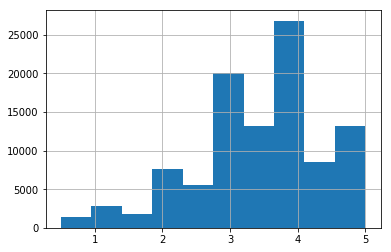

In [164]:
df.rating.hist()

In [165]:
rmse_df

,RMSE - CV 5 folds
SVD,0.872621
NMF,0.920924
BaselineOnly,0.869363


Our first thought was that SVD would give us the best result but it did not as RMSE for SVD is little bit higher than BaselineOnly's. We cannot, however, strictly say that one should always prefer BaselineOnly to SGD based SVD - depending on the case, one can still use SVD if that is more suitable for his/her own purpose. 

We then have to think about why SVD had higher RMSE. 

Our guess is that it could be something to do with feature scaling issue - how ratings are scaled. 
From the documentation of the dataset we used (http://files.grouplens.org/datasets/movielens/ml-latest-small-README.html) and from the rating historgram, we know that ratings are half-star incremented. On the other hand, alternative dataset with 1 million ratings, which we could not run SVD due to the memory issue, (http://files.grouplens.org/datasets/movielens/ml-1m-README.txt) contains whole-star ratings only. 

According to benchmark RMSE examples on http://surpriselib.com/, we see that RMSE for SVD using 100k dataset is usually around 0.934 but only 0.873 using 1m dataset.

Since SVD is based on SGD, (https://scikit-learn.org/stable/modules/sgd.html) there are several disdvantages - 1) SGD requires a number of hyperparameters such as the regularization parameter and the number of iterations. 2) SGD is sensitive to feature scaling.

For the future reference, it will be a worth try to compare the RMSE of each model one another in different rating scales to see if there will be any improvement.